In [1]:
#import dependents
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 6]
from scipy.optimize import least_squares
pd.options.display.float_format = '{:,.3f}'.format
pd.get_option("display.max_columns")
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)

import datetime

In [2]:
def cleanDF(df):
    df = df.drop(df[(df.year == 2020) & (df.quarter == 2)].index)
    df = df.drop(df[(df.year == 2020) & (df.quarter == 3)].index)
    df.index = range(0,len(df))
    #creat Vs
    df.rename(columns = {'Duration of job vacancy, all durations': 'all'}, inplace = True)
    df.rename(columns = {'Less than 15 days': 'a000b014'}, inplace = True)
    df.rename(columns = {'15 to 29 days': 'a015b029'}, inplace = True)
    df.rename(columns = {'30 to 59 days': 'a030b059'}, inplace = True)
    df.rename(columns = {'60 to 89 days': 'a060b089'}, inplace = True)
    df.rename(columns = {'90 days or more': 'a090binf'}, inplace = True)
    df.rename(columns = {'90 to 119 days': 'a090b119'}, inplace = True)
    df.rename(columns = {'120 days or more': 'a120binf'}, inplace = True)
    df['a000binf'] = df['a000b014'] + df['a015b029'] + df['a030b059'] + df['a060b089'] + df['a090binf']
    #rearrage columns:
    df = df[['t', 'year', 'quarter', 'all',
             'a000binf', 'a000b014', 'a015b029', 'a030b059', 'a060b089', 'a090binf', 'a090b119', 'a120binf']]
    return df

In [3]:
df_all = cleanDF(pd.read_csv('data/all.csv'))
#by occupation type
df_cultur = cleanDF(pd.read_csv('data/art culture recreation and sport.csv'))
df_buzfin = cleanDF(pd.read_csv('data/Business finance and administration.csv'))
df_social = cleanDF(pd.read_csv('data/education law and social community and government services.csv'))
df_health = cleanDF(pd.read_csv('data/Health.csv'))
df_manage = cleanDF(pd.read_csv('data/management.csv'))
df_manufa = cleanDF(pd.read_csv('data/manufacturing and utilities.csv'))
df_engine = cleanDF(pd.read_csv('data/Natural and applied sciences and related.csv'))
df_agricu = cleanDF(pd.read_csv('data/Natural resources agriculture and related production.csv'))
df_servic = cleanDF(pd.read_csv('data/Sales and service.csv'))
df_trades = cleanDF(pd.read_csv('data/Trades transport and equipment operators and related.csv'))
df_0class = cleanDF(pd.read_csv('data/Unclassified.csv'))
#by province
df_ON = cleanDF(pd.read_csv('data/pov_ON.csv'))
df_QC = cleanDF(pd.read_csv('data/pov_QC.csv'))
df_BC = cleanDF(pd.read_csv('data/pov_BC.csv'))
df_AB = cleanDF(pd.read_csv('data/pov_AB.csv'))
df_MB = cleanDF(pd.read_csv('data/pov_MB.csv'))
df_SK = cleanDF(pd.read_csv('data/pov_SK.csv'))

In [4]:
POV_list = ['ON', 'QC', 'BC', 'AB', 'MB', 'SK']
NOC_list = ['cultur', 'buzfin', 'social', 'health', 'manage', 'manufa', 
            'engine', 'agricu', 'servic', 'trades', '0class']
VacancyCharacteristics = POV_list + NOC_list

Employing the steady-state assumption, we can model job vacancies over time as:
$$
v(t)=V_0(1-q)^t
$$
where $V_0$ is the inflow of new job vacancies created at $t=0$, and $q$ is the probability of a vacancy being filled during period $t$. The geometric series of the model would be:
$$
V_{a,b}=\sum_{t=a}^{b}v(t) \\
V_{a,b}={V_0(1-q)^a\left(1-(1-q)^b\right)\over1-q}
$$

In [5]:
def genDF0(df, df0, quarter):
    #df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      #'V':df.loc[quarter,'a000binf'],'a':float(0),'b':np.inf,'id':'a000binf'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a000b014'],'a':float(0),'b':float(14), 'id':'a000b014'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a015b029'],'a':float(15),'b':float(29),'id':'a015b029'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a030b059'],'a':float(30),'b':float(59),'id':'a030b059'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a060b089'],'a':float(60),'b':float(89),'id':'a060b089'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a090binf'],'a':float(90),'b':np.inf,'id':'a090binf'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a090b119'],'a':float(90),'b':float(119),'id':'a090b119'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a120binf'],'a':float(120),'b':np.inf,'id':'a120binf'},ignore_index=True)
    df0 = df0[df0['V'].notna()]
    df0['V'] = df0['V'].astype(float, errors='ignore')
    return df0

coeffs0 = [10000, 0.5] #initial guess
def fitting(df0, coeffs0):
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    a = df0['a'].to_numpy()
    b = df0['b'].to_numpy()
    v = df0['V'].to_numpy()
    def model(coeffs, a , b):
        zeroInf = coeffs[0] / (1 - coeffs[1])
        adj = (coeffs[1] ** a) * (1 - (coeffs[1] ** b))
        return zeroInf * adj
    def residual(coeffs):
        return model(coeffs, a , b) - v 
    fit = least_squares(residual, coeffs0)
    return fit

In [6]:
def NLS(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for quarter in range(len(df)):
        df0 = genDF0(df, df0, quarter)
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    fit = fitting(df0, coeffs0) 
    #record
    v0 = fit.x[0]
    q = 1 - fit.x[1]
    ε = pd.Series(fit.fun)
    df0['ε'] = ε.values
    df['ε_a000binf'] = np.nan
    df['ε_a000b014'] = np.nan
    df['ε_a015b029'] = np.nan
    df['ε_a030b059'] = np.nan
    df['ε_a060b089'] = np.nan
    df['ε_a090binf'] = np.nan
    df['ε_a090b119'] = np.nan
    df['ε_a120binf'] = np.nan
    for i in range(len(df0)):
        ε_value = df0.loc[i, 'ε']
        year = df0.loc[i, 'year']
        quarter = df0.loc[i, 'quarter']
        id_name = df0.loc[i, 'id']
        df[f'ε_{id_name}'][(df["year"] == year) & (df["quarter"] == quarter)] = ε_value
    if q != 0.5:
        df['v0'] = v0
        df['q'] = q
    else:
        pass
    return df, v0 , q

In [7]:
def NLS_yearly(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for year in range(2015, 2022+1 ,1):
        dfYEAR = df[(df['year'] == year)].copy()
        dfYEAR.index = range(0,len(dfYEAR))
        try:
            fit = NLS(dfYEAR) #[0]: table, [1]:V0, [2]: q
            dfYEAR = fit[0]
            df0 = df0.append(dfYEAR)
        except:
            pass
    return df0

In [8]:
def NLS_quarterly(df):
    df = df.copy()
    for quarter in range(len(df)):
        df0 = pd.DataFrame()
        df0 = genDF0(df, df0, quarter)
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        if len(df0.index) >= 2:
            fit = fitting(df0, coeffs0) 
        #record
            v0 = fit.x[0]
            q = 1- fit.x[1]
            if q != coeffs0[1]:
                df.loc[quarter, 'v0'] = v0
                df.loc[quarter, 'q'] = q
            else:
                pass
            idList = df0['id'].tolist()
            for i in range(len(fit.fun)):
                df.loc[quarter, f'ε_{idList[i]}'] = fit.fun[i]
            df0 = df0.iloc[0:0] #clear df0
    return df

In [9]:
def name(df):
    df = df.replace({'ON': 'Ontario', 'QC': 'Quebec', 'BC': 'British Columbia',
                     'AB': 'Alberta', 'MB': 'Manitoba', 'SK': 'Saskatchewan', 
                     'cultur': 'Art culture recreation and sport',
                     'buzfin': 'Business finance and administration',
                     'social': 'Education, law, social, community, and government services',
                     'health': 'Health',
                     'manage': 'Management',
                     'manufa': 'Manufacturing and utilities',
                     'engine': 'Natural and applied sciences and related',
                     'agricu': 'Natural resources agriculture and related production',
                     'servic': 'Sales and service',
                     'trades': 'Trades transport and equipment operators and related',
                     '0class': 'Unclassified'})
    return df

In [10]:
def date(df):
    df = df.copy()
    df['quarter'] = df['quarter'].replace({1: '-01-01',
                                           2: '-04-01',
                                           3: '-07-01',
                                           4: '-10-01'})
    df['year'] = df['year'].astype(str)
    df['date'] = df['year'] + df['quarter']
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(['t' , 'year', 'quarter'], axis=1)
    return df

In [11]:
#fitting
fitAll_all = NLS(df_all) #[0]: table, [1]:V0, [2]: q, [3]: standard error of the model
fitYear_all = NLS_yearly(df_all)
fitQuarter_all = NLS_quarterly(df_all)

# ALL FIT

In [12]:
#fitting
for i in VacancyCharacteristics:
    df = globals()[f'df_{i}']
    globals()[f'fitAll_{i}'] = NLS(df)

In [13]:
fitAll_result = pd.DataFrame()
fitAll_result = fitAll_result.append({'Vacancy Characteristics': 'All', 'v0': fitAll_all[1], 'q':fitAll_all[2],
                                      'Average ε_a000binf': fitAll_all[0]['ε_a000binf'].mean(),
                                      'Average ε_a000b014': fitAll_all[0]['ε_a000b014'].mean(),
                                      'Average ε_a015b029': fitAll_all[0]['ε_a015b029'].mean(),
                                      'Average ε_a030b059': fitAll_all[0]['ε_a030b059'].mean(),
                                      'Average ε_a060b089': fitAll_all[0]['ε_a060b089'].mean(),
                                      'Average ε_a090binf': fitAll_all[0]['ε_a090binf'].mean(),
                                      'Average ε_a090b119': fitAll_all[0]['ε_a090b119'].mean(),
                                      'Average ε_a120binf': fitAll_all[0]['ε_a120binf'].mean()
                                     }, ignore_index=True)
#result table
for j in VacancyCharacteristics:
    fit = globals()[f'fitAll_{j}']
    fitAll_result = fitAll_result.append({'Vacancy Characteristics': j, 'v0': fit[1], 'q':fit[2],
                                          'Average ε_a000binf': fit[0]['ε_a000binf'].mean(),
                                          'Average ε_a000b014': fit[0]['ε_a000b014'].mean(),
                                          'Average ε_a015b029': fit[0]['ε_a015b029'].mean(),
                                          'Average ε_a030b059': fit[0]['ε_a030b059'].mean(),
                                          'Average ε_a060b089': fit[0]['ε_a060b089'].mean(),
                                          'Average ε_a090binf': fit[0]['ε_a090binf'].mean(),
                                          'Average ε_a090b119': fit[0]['ε_a090b119'].mean(),
                                          'Average ε_a120binf': fit[0]['ε_a120binf'].mean()
                                         }, ignore_index=True)

fitAll_result = name(fitAll_result)
fitAll_result = fitAll_result.set_index(['Vacancy Characteristics'])
#display(fitAll_result)
#fitAll_result.to_excel("Table5-1.xlsx")  
fitAll_result.describe()

,Average ε_a000b014,Average ε_a000binf,Average ε_a015b029,Average ε_a030b059,Average ε_a060b089,Average ε_a090b119,Average ε_a090binf,Average ε_a120binf,q,v0
count,18.000,0.000,18.000,18.000,18.000,17.000,18.000,18.000,18.000,18.000
mean,"-7,635.883",NaN,-919.884,"3,509.813","6,004.435","2,425.609","-4,820.474","-23,493.367",0.021,"1,061.408"
std,"12,324.538",NaN,"2,805.119","7,276.994","10,523.149","4,972.150","9,708.589","35,995.262",0.011,"1,513.990"
min,"-53,137.873",NaN,"-7,912.872",-862.806,-28.897,"-4,011.567","-34,122.826","-151,735.554",0.005,123.031
25%,"-9,310.880",NaN,"-2,322.659",427.816,709.821,-87.703,"-5,278.122","-25,124.045",0.015,235.408
50%,"-3,005.117",NaN,-245.532,"1,059.536","2,758.882",931.411,"-1,591.856","-10,079.768",0.019,378.555
75%,"-1,894.520",NaN,417.151,"1,896.502","7,838.860","2,513.080",-619.417,"-4,271.341",0.031,"1,151.655"
max,117.782,NaN,"3,066.686","30,283.183","45,247.208","16,912.913","4,492.280",-172.714,0.040,"5,727.879"


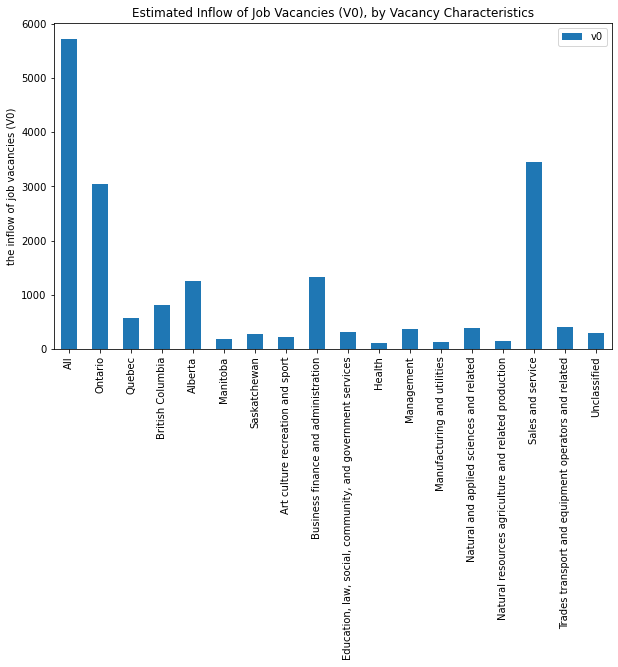

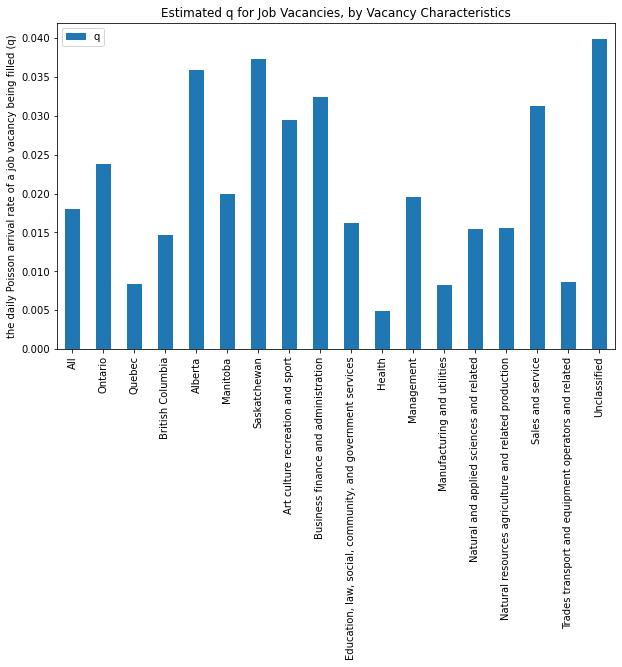

In [14]:
fitAll_result[['v0']].plot(kind="bar")
plt.xlabel("")
plt.ylabel("the inflow of job vacancies (V0)")
plt.title("Estimated Inflow of Job Vacancies (V0), by Vacancy Characteristics")
plt.show()

fitAll_result[['q']].plot(kind="bar")
plt.xlabel("")
plt.ylabel("the daily Poisson arrival rate of a job vacancy being filled (q)")
plt.title("Estimated q for Job Vacancies, by Vacancy Characteristics")
plt.show()

# Yearly FIT

In [15]:
#fitting
for i in VacancyCharacteristics:
    df = globals()[f'df_{i}']
    globals()[f'fitYear_{i}'] = NLS_yearly(df)

In [16]:
describeYEARLY = pd.DataFrame()
df = fitYear_all
for year in range(2015, 2022 + 1, 1):
    dfYEAR = df[(df['year'] == year)].copy()
    dfYEAR.index = range(0,len(dfYEAR))
    dfYEAR = dfYEAR.describe().iloc[:, 12:].loc[['mean']]
    dfYEAR['Vacancy Characteristics'] = "All"
    dfYEAR['year'] = year
    dfYEAR = dfYEAR.set_index(['Vacancy Characteristics', 'year'])
    describeYEARLY = describeYEARLY.append(dfYEAR)
for i in VacancyCharacteristics:
    df = globals()[f'fitYear_{i}']
    for year in range(2015, 2022 + 1, 1):
        dfYEAR = df[(df['year'] == year)].copy()
        dfYEAR.index = range(0,len(dfYEAR))
        dfYEAR = dfYEAR.describe().iloc[:, 12:].loc[['mean']]
        dfYEAR['Vacancy Characteristics'] = i
        dfYEAR['year'] = year
        dfYEAR = name(dfYEAR)
        dfYEAR = dfYEAR.set_index(['Vacancy Characteristics', 'year'])
        describeYEARLY = describeYEARLY.append(dfYEAR)
describeYEARLY = describeYEARLY[['v0', 'q', 'ε_a000binf', 'ε_a000b014', 'ε_a015b029', 'ε_a030b059', 
                                 'ε_a060b089', 'ε_a090binf', 'ε_a090b119', 'ε_a120binf']]
describeYEARLY

v0  \
Vacancy Characteristics                                    year              
All                                                        2015 10,031.864   
                                                           2016  9,151.419   
                                                           2017  8,999.223   
                                                           2018  8,558.422   
                                                           2019  8,598.493   
                                                           2020  3,803.480   
                                                           2021  4,105.406   
                                                           2022  3,106.405   
Ontario                                                    2015  4,195.433   
                                                           2016  3,820.313   
                                                           2017  3,753.090   
                                                           2018  3,569.303   
                                                           2019  3,576.309   
                                                           2020  2,663.017   
                                                           2021  2,070.717   
                                                           2022  1,528.452   
Quebec                                                     2015  1,624.496   
                                                           2016  1,629.234   
                                                           2017  1,576.018   
                                                           2018  1,484.992   
                                                           2019  1,441.327   
                                                           2020    532.989   
                                                           2021    615.855   
                                                           2022    538.670   
British Columbia                                           2015  1,478.263   
                                                           2016  1,487.994   
                                                           2017  1,367.287   
                                                           2018  1,232.964   
                                                           2019  1,368.993   
                                                           2020    437.233   
                                                           2021    665.162   
                                                           2022    493.425   
Alberta                                                    2015  1,400.423   
                                                           2016  1,116.353   
                                                           2017  1,266.939   
                                                           2018  1,285.112   
                                                           2019  1,170.333   
                                                           2020  1,392.566   
                                                           2021  1,295.653   
                                                           2022    675.507   
Manitoba                                                   2015    408.119   
                                                           2016    354.631   
                                                           2017    299.769   
                                                           2018    223.513   
                                                           2019    277.013   
                                                           2020    121.267   
                                                           2021    164.763   
                                                           2022    116.244   
Saskatchewan                                               2015    280.817   
                                                           2016    253.455   
                

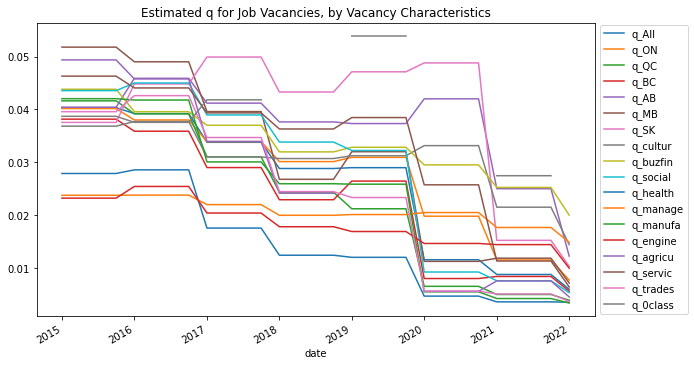

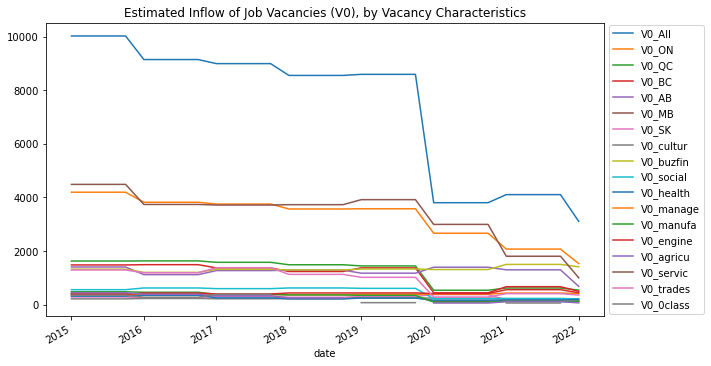

In [17]:
plot_year = pd.DataFrame()
plot_year_all = date(fitYear_all)[['date','q']].copy().set_index(['date'])
plot_year_all = plot_year_all.rename({'q': 'q_All'}, axis='columns')
plot_year = plot_year.append(plot_year_all)
for i in VacancyCharacteristics:
    df = globals()[f'fitYear_{i}']
    df = date(df).set_index(['date'])
    df = df[['q']]
    df = df.rename({'q': f'q_{i}'}, axis='columns')
    plot_year =pd.merge(plot_year, df, on = "date", how = "outer")
plot_year.plot()
plt.title('Estimated q for Job Vacancies, by Vacancy Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

plot_year = pd.DataFrame()
plot_year_all = date(fitYear_all)[['date','v0']].copy().set_index(['date'])
plot_year_all = plot_year_all.rename({'v0': 'V0_All'}, axis='columns')
plot_year = plot_year.append(plot_year_all)
for i in VacancyCharacteristics:
    df = globals()[f'fitYear_{i}']
    df = date(df).set_index(['date'])
    df = df[['v0']]
    df = df.rename({'v0': f'V0_{i}'}, axis='columns')
    plot_year =pd.merge(plot_year, df, on = "date", how = "outer")
plot_year.plot()
plt.title('Estimated Inflow of Job Vacancies (V0), by Vacancy Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Quarterly FIT

In [18]:
#fitting
for i in VacancyCharacteristics:
    df = globals()[f'df_{i}']
    globals()[f'fitQuarter_{i}'] = NLS_quarterly(df)

In [19]:
describeQUARTERLY = pd.DataFrame()
for i in VacancyCharacteristics:
    df = globals()[f'fitQuarter_{i}']
    df = df.describe().iloc[:, 12:]
    df = df.loc[['mean']]
    df['Vacancy Characteristics'] = i
    df = df.set_index('Vacancy Characteristics')
    describeQUARTERLY = describeQUARTERLY.append(df)
#describeQUARTERLY

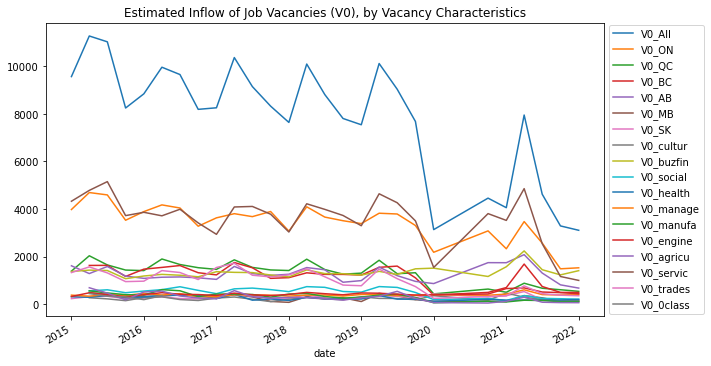

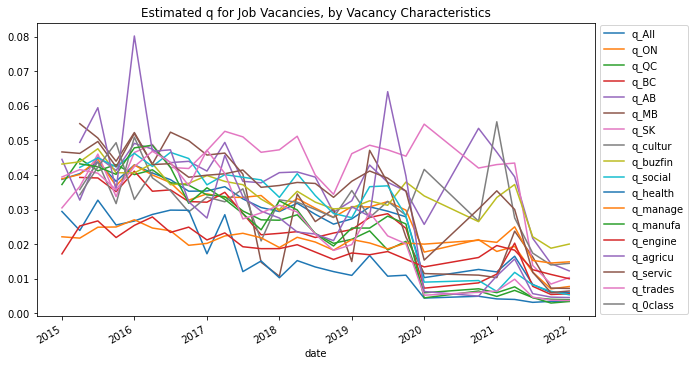

In [20]:
plot_quarter = pd.DataFrame()
plot_quarter_all = date(fitQuarter_all)[['date','v0']].copy().set_index(['date'])
plot_quarter_all = plot_quarter_all.rename({'v0': 'V0_All'}, axis='columns')
plot_quarter = plot_quarter.append(plot_quarter_all)
for i in VacancyCharacteristics:
    df = globals()[f'fitQuarter_{i}']
    df = date(df).set_index(['date'])
    df = df[['v0']]
    df = df.rename({'v0': f'V0_{i}'}, axis='columns')
    plot_quarter =pd.merge(plot_quarter, df, on = "date", how = "outer")
plot_quarter.plot()
plt.title('Estimated Inflow of Job Vacancies (V0), by Vacancy Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

plot_quarter = pd.DataFrame()
plot_quarter_all = date(fitQuarter_all)[['date','q']].copy().set_index(['date'])
plot_quarter_all = plot_quarter_all.rename({'q': 'q_All'}, axis='columns')
plot_quarter = plot_quarter.append(plot_quarter_all)
for i in VacancyCharacteristics:
    df = globals()[f'fitQuarter_{i}']
    df = date(df).set_index(['date'])
    df = df[['q']]
    df = df.rename({'q': f'q_{i}'}, axis='columns')
    plot_quarter = pd.merge(plot_quarter, df, on = "date", how = "outer")
plot_quarter.plot()
plt.title('Estimated q for Job Vacancies, by Vacancy Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

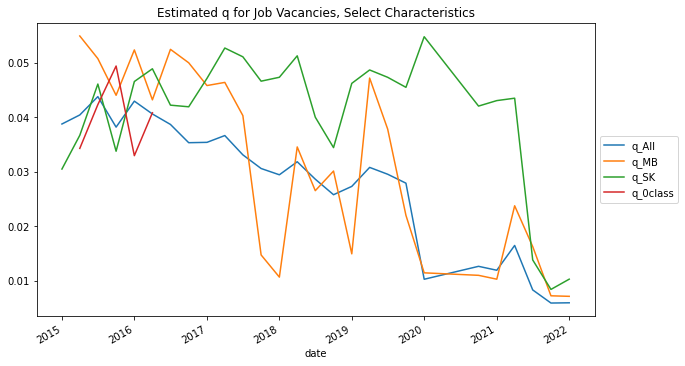

In [21]:
select = ['MB', 'SK', '0class']
plot_quarter = pd.DataFrame()
plot_quarter_all = date(fitQuarter_all)[['date','q']].copy().set_index(['date'])
plot_quarter_all = plot_quarter_all.rename({'q': 'q_All'}, axis='columns')
plot_quarter = plot_quarter.append(plot_quarter_all)
for i in select:
    df = globals()[f'fitQuarter_{i}']
    df = date(df).set_index(['date'])
    df = df[['q']]
    df = df.rename({'q': f'q_{i}'}, axis='columns')
    plot_quarter = pd.merge(plot_quarter, df, on = "date", how = "outer")
plot_quarter.plot()
plt.title('Estimated q for Job Vacancies, Select Characteristics')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# PLOTTING

In [22]:
def plot(df, year, quarter):
    year = int(year)
    quarter = int(quarter)
    df = df[(df['year'] == year) & (df['quarter'] == quarter)]
    df.index = range(0,len(df))
    index = ['day 0-∞','day 00-14','day 15-29','day 30-59','day 60-89','day 90-∞','day 90 - 119','day 120-∞']
    obs = df[['a000binf','a000b014','a015b029','a030b059','a060b089','a090binf','a090b119','a120binf']].T
    obs['Time Interval'] = index
    obs.rename(columns = {0: 'observation'}, inplace = True)
    obs = obs.set_index('Time Interval')
    res = df[['ε_a000binf','ε_a000b014','ε_a015b029','ε_a030b059',
              'ε_a060b089','ε_a090binf','ε_a090b119','ε_a120binf']].T
    res['Time Interval'] = index
    res.rename(columns = {0: 'residual'}, inplace = True)
    res = res.set_index('Time Interval')
    df0 = pd.concat([obs, res], axis=1)    
    df0['model est.'] = df0['observation'] + df0['residual']
    #display and plot
    v0 = df.loc[0, 'v0']
    q = df.loc[0, 'q']
    df0 = df0[['observation', 'model est.', 'residual']]
    display(df0)
    print(f'V0={v0}, q={q}')
    df0.plot(kind="bar")
    plt.xticks(rotation=30, horizontalalignment="center")
    plt.xlabel("Age Distribution")
    plt.ylabel("Job Vacancies")
    plt.title(f"Observation, Estimation, and Residual - {year} Q{quarter}")
    plt.show()

,observation,model est.,residual
Time Interval,,,
day 0-∞,"890,385.000",NaN,NaN
day 00-14,"173,840.000","71,434.535","-102,405.465"
day 15-29,"149,430.000","99,122.687","-50,307.313"
day 30-59,"156,055.000","121,093.553","-34,961.447"
day 60-89,"90,075.000","85,458.505","-4,616.495"
day 90-∞,"320,985.000","61,713.840","-259,271.160"
day 90 - 119,"51,250.000","54,639.342","3,389.342"
day 120-∞,"269,740.000","35,746.589","-233,993.411"


V0=5727.878829896838, q=0.01803712693041426


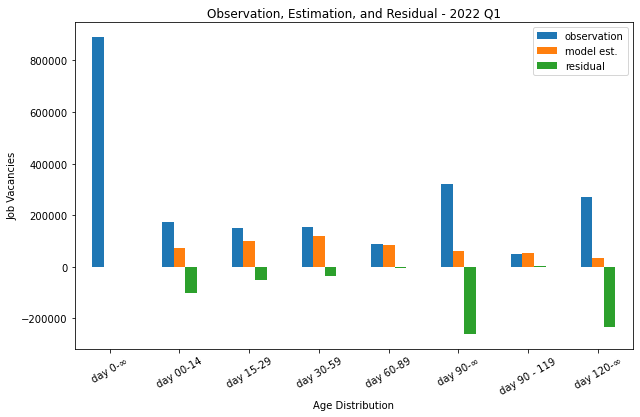

In [23]:
plot(fitAll_all[0], 2022, 1)

# Descriptive Statistics

In [24]:
POVdict = {'ON': 'Ontario', 'QC': 'Quebec', 'BC': 'British Columbia',
           'AB': 'Alberta', 'MB': 'Manitoba', 'SK': 'Saskatchewan'}
NOCdict = {'cultur': 'Art culture recreation and sport',
           'buzfin': 'Business finance and administration',
           'social': 'Education, law, social, community, and government services',
           'health': 'Health',
           'manage': 'Management',
           'manufa': 'Manufacturing and utilities',
           'engine': 'Natural and applied sciences and related',
           'agricu': 'Natural resources agriculture and related production',
           'servic': 'Sales and service',
           'trades': 'Trades transport and equipment operators and related',
           '0class': 'Unclassified'}

In [25]:
display(df_all.describe().iloc[:, 3:])
print('')
for i in VacancyCharacteristics:
    print(f'{i} ==================================================================================')
    df = globals()[f'df_{i}']
    display(df.describe().iloc[:, 3:])

,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,27.000,27.000,27.000,27.000,27.000,27.000,7.000,7.000
mean,"528,156.852","455,249.444","124,572.407","103,818.704","90,810.370","40,211.296","95,836.667","37,726.429","187,482.143"
std,"160,881.200","190,373.938","24,509.076","25,767.938","35,414.894","23,516.801","89,892.310","15,218.909","74,132.078"
min,"330,215.000","265,055.000","96,690.000","71,795.000","48,650.000","16,660.000","29,350.000","22,655.000","122,895.000"
25%,"407,995.000","325,052.500","107,690.000","87,737.500","64,557.500","24,325.000","39,497.500","24,667.500","125,007.500"
50%,"506,140.000","384,040.000","118,755.000","96,630.000","82,760.000","34,600.000","61,300.000","31,525.000","144,185.000"
75%,"556,847.500","482,400.000","134,637.500","108,097.500","96,062.500","42,007.500","109,357.500","51,280.000","255,015.000"
max,"915,545.000","915,545.000","200,195.000","178,810.000","184,600.000","105,960.000","343,260.000","58,010.000","285,250.000"



ON ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,27.000,7.000,7.000
mean,"203,984.074","179,394.808","50,454.444","42,627.593","36,292.222","15,939.231","32,538.704","13,287.857","60,245.000"
std,"55,630.273","66,982.973","8,930.350","9,540.784","13,018.481","8,410.681","29,718.519","6,319.794","27,148.354"
min,"138,450.000","115,660.000","39,280.000","30,505.000","22,655.000","6,975.000","10,505.000","7,030.000","36,335.000"
25%,"172,280.000","141,103.750","45,067.500","36,737.500","28,822.500","10,942.500","15,772.500","7,842.500","37,797.500"
50%,"190,440.000","151,670.000","47,330.000","40,505.000","32,630.000","13,157.500","21,500.000","11,380.000","45,640.000"
75%,"208,612.500","183,353.750","53,897.500","44,312.500","36,652.500","16,413.750","35,140.000","18,012.500","82,752.500"
max,"348,260.000","348,260.000","72,390.000","71,500.000","72,265.000","39,635.000","121,535.000","22,895.000","98,640.000"


QC ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,27.000,27.000,27.000,27.000,27.000,27.000,7.000,7.000
mean,"115,140.556","101,717.037","22,645.000","21,005.741","20,178.889","9,998.704","27,888.704","11,129.286","63,669.286"
std,"55,486.314","59,293.690","5,111.649","6,994.821","10,401.922","7,676.359","31,630.686","3,764.295","24,062.571"
min,"52,205.000","44,170.000","15,540.000","11,045.000","7,965.000","2,720.000","4,705.000","6,235.000","38,960.000"
25%,"67,347.500","58,225.000","19,602.500","14,997.500","11,505.000","4,272.500","6,635.000","8,292.500","43,502.500"
50%,"114,215.000","87,170.000","21,565.000","19,670.000","18,615.000","7,760.000","15,690.000","10,750.000","53,070.000"
75%,"138,975.000","118,142.500","25,072.500","25,260.000","23,932.500","11,290.000","34,032.500","14,500.000","86,827.500"
max,"238,140.000","238,140.000","38,565.000","36,240.000","45,410.000","29,300.000","108,330.000","15,335.000","92,995.000"


BC ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,26.000,26.000,26.000,26.000,26.000,7.000,7.000
mean,"95,352.037","80,255.962","20,164.423","17,900.962","16,680.192","7,276.346","18,234.038","6,605.714","33,530.000"
std,"26,119.643","31,688.417","4,814.155","4,187.933","5,926.898","4,136.077","15,552.797","2,523.421","12,066.205"
min,"59,970.000","44,690.000","14,290.000","10,570.000","8,095.000","2,845.000","5,875.000","3,870.000","23,035.000"
25%,"72,895.000","57,611.250","17,680.000","15,523.750","12,083.750","3,882.500","7,891.250","4,710.000","23,740.000"
50%,"92,645.000","71,682.500","18,675.000","16,772.500","16,707.500","6,605.000","12,562.500","5,145.000","25,460.000"
75%,"106,002.500","90,002.500","21,342.500","19,568.750","18,250.000","8,447.500","24,263.750","9,170.000","44,770.000"
max,"157,575.000","157,570.000","37,790.000","30,055.000","31,565.000","17,680.000","58,665.000","9,465.000","49,195.000"


AB ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,26.000,27.000,26.000,26.000,7.000,7.000
mean,"56,904.444","47,630.962","16,015.000","11,543.846","9,297.963","3,480.192","7,308.077","2,953.571","11,051.429"
std,"14,246.583","16,538.848","3,604.195","3,561.544","3,529.517","1,755.554","5,454.494","2,003.511","5,038.001"
min,"39,150.000","29,180.000","11,705.000","6,990.000","4,505.000","1,965.000","3,315.000",865.000,"6,235.000"
25%,"46,907.500","37,140.000","12,830.000","9,255.000","7,345.000","2,536.250","4,266.250","1,587.500","7,045.000"
50%,"51,265.000","42,642.500","15,355.000","10,565.000","8,605.000","2,965.000","5,317.500","1,800.000","8,645.000"
75%,"62,205.000","48,478.750","17,702.500","12,607.500","9,667.500","3,658.750","7,152.500","4,300.000","15,030.000"
max,"88,165.000","88,165.000","24,945.000","20,870.000","19,120.000","9,020.000","24,565.000","6,235.000","18,330.000"


MB ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,26.000,26.000,26.000,26.000,7.000,7.000
mean,"15,682.778","13,896.154","4,267.963","2,928.462","2,424.038","1,178.269","3,112.115","1,295.714","4,967.143"
std,"4,482.703","5,496.103",928.784,981.111,"1,093.675",709.332,"2,335.361",556.503,"1,680.625"
min,"10,495.000","7,870.000","2,830.000","1,890.000","1,330.000",305.000,585.000,670.000,"3,150.000"
25%,"13,252.500","10,451.250","3,545.000","2,403.750","1,767.500",660.000,"1,202.500",915.000,"3,957.500"
50%,"14,835.000","12,172.500","4,325.000","2,635.000","2,105.000","1,067.500","2,710.000","1,125.000","4,270.000"
75%,"16,477.500","16,108.750","4,917.500","2,952.500","2,687.500","1,398.750","4,375.000","1,645.000","5,845.000"
max,"27,520.000","27,520.000","6,825.000","6,070.000","5,085.000","3,055.000","9,170.000","2,155.000","7,745.000"


SK ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,27.000,7.000,7.000
mean,"11,937.593","10,438.654","3,597.222","2,372.222","1,809.815",773.269,"1,889.815",752.143,"3,255.714"
std,"3,570.966","4,170.190",926.125,796.530,832.595,416.622,"1,537.765",255.096,"1,462.502"
min,"8,435.000","6,830.000","2,350.000","1,385.000","1,090.000",365.000,835.000,480.000,"1,730.000"
25%,"9,400.000","7,483.750","2,897.500","1,900.000","1,350.000",511.250,997.500,582.500,"2,117.500"
50%,"10,775.000","9,002.500","3,545.000","2,085.000","1,490.000",675.000,"1,190.000",630.000,"2,505.000"
75%,"11,970.000","11,298.750","4,015.000","2,602.500","1,810.000",752.500,"2,142.500",897.500,"4,602.500"
max,"20,325.000","20,330.000","6,230.000","4,190.000","4,360.000","1,955.000","6,310.000","1,195.000","5,115.000"


cultur ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,26.000,26.000,26.000,26.000,26.000,7.000,7.000
mean,"11,074.444","10,076.154","2,988.846","2,510.769","2,310.769",856.346,"1,409.423",584.286,"1,987.857"
std,"2,874.381","3,141.618",863.009,676.155,733.133,535.822,"1,032.269",308.064,943.521
min,"6,560.000","5,840.000","1,605.000","1,465.000","1,215.000",210.000,325.000,200.000,880.000
25%,"8,655.000","7,683.750","2,411.250","1,878.750","1,801.250",422.500,740.000,330.000,"1,260.000"
50%,"10,600.000","9,465.000","2,820.000","2,622.500","2,227.500",692.500,"1,060.000",645.000,"1,675.000"
75%,"12,895.000","11,638.750","3,518.750","3,175.000","2,738.750","1,076.250","1,827.500",795.000,"2,780.000"
max,"16,450.000","16,450.000","4,850.000","3,690.000","4,265.000","2,165.000","3,975.000",995.000,"3,280.000"


buzfin ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,27.000,26.000,7.000,7.000
mean,"57,583.148","55,726.923","17,609.074","13,384.630","11,562.037","4,828.333","7,932.308","3,388.571","10,337.143"
std,"17,020.437","18,219.572","4,068.050","3,473.372","4,343.680","2,499.413","4,656.165","1,057.866","3,831.737"
min,"35,355.000","33,200.000","12,055.000","9,300.000","6,350.000","2,235.000","2,325.000","2,355.000","6,320.000"
25%,"46,217.500","43,201.250","15,237.500","11,275.000","8,562.500","3,000.000","4,916.250","2,537.500","7,400.000"
50%,"55,880.000","53,410.000","16,155.000","12,865.000","10,900.000","4,345.000","7,135.000","3,050.000","8,455.000"
75%,"60,787.500","60,053.750","18,322.500","13,822.500","12,480.000","5,482.500","9,056.250","4,215.000","13,450.000"
max,"102,715.000","102,715.000","28,715.000","23,050.000","23,040.000","11,385.000","20,695.000","4,810.000","15,885.000"


social ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,26.000,26.000,26.000,26.000,7.000,7.000
mean,"32,387.407","28,590.000","7,889.444","6,651.538","5,504.423","2,243.846","6,230.962","2,430.714","13,939.286"
std,"12,933.588","14,623.599","2,056.724","1,957.254","2,801.789","1,508.938","6,843.982",982.969,"4,383.224"
min,"18,555.000","14,530.000","5,000.000","4,045.000","2,585.000",705.000,"1,320.000","1,505.000","9,410.000"
25%,"21,122.500","18,238.750","6,442.500","5,208.750","3,246.250","1,150.000","1,770.000","1,705.000","10,965.000"
50%,"32,475.000","24,080.000","7,095.000","6,160.000","4,862.500","1,697.500","3,000.000","2,145.000","12,945.000"
75%,"35,772.500","33,863.750","8,835.000","7,423.750","6,713.750","2,671.250","9,182.500","3,010.000","15,850.000"
max,"66,975.000","66,970.000","13,125.000","10,775.000","12,765.000","6,065.000","25,525.000","3,935.000","21,590.000"


health ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,26.000,26.000,26.000,7.000,7.000
mean,"39,419.074","35,066.154","6,230.000","5,455.926","6,309.231","3,974.038","12,937.885","5,375.000","27,458.571"
std,"20,097.637","22,721.064","1,955.231","1,779.709","3,750.253","2,999.737","13,099.057","1,270.436","7,289.546"
min,"20,935.000","15,240.000","3,625.000","3,120.000","2,555.000","1,110.000","2,275.000","3,170.000","15,595.000"
25%,"23,695.000","18,793.750","4,902.500","4,147.500","3,437.500","1,720.000","3,882.500","4,655.000","23,372.500"
50%,"34,190.000","26,055.000","5,515.000","4,940.000","4,970.000","2,957.500","7,112.500","6,005.000","26,940.000"
75%,"42,425.000","40,488.750","7,412.500","6,610.000","6,858.750","5,692.500","16,282.500","6,335.000","33,912.500"
max,"82,830.000","82,830.000","12,485.000","9,610.000","14,415.000","12,925.000","41,580.000","6,470.000","35,105.000"


manage ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,27.000,7.000,7.000
mean,"27,797.963","26,908.462","6,275.556","5,980.741","6,406.296","3,111.346","5,014.074","1,965.000","5,223.571"
std,"5,137.601","5,643.095","1,203.489",970.270,"1,345.336",829.339,"1,773.843",592.790,"1,577.016"
min,"22,055.000","20,740.000","4,980.000","4,500.000","4,685.000","2,180.000","3,375.000","1,125.000","3,665.000"
25%,"24,450.000","23,018.750","5,425.000","5,452.500","5,312.500","2,557.500","3,810.000","1,607.500","3,950.000"
50%,"26,275.000","25,435.000","5,955.000","5,655.000","6,400.000","3,010.000","4,765.000","1,740.000","4,395.000"
75%,"29,010.000","27,698.750","6,582.500","6,292.500","6,717.500","3,211.250","5,542.500","2,507.500","6,705.000"
max,"41,645.000","41,645.000","9,795.000","8,160.000","9,685.000","5,275.000","9,855.000","2,660.000","7,195.000"


manufa ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,26.000,26.000,26.000,26.000,26.000,7.000,7.000
mean,"28,322.407","23,275.000","5,213.846","5,164.038","4,541.538","2,099.615","6,255.962","2,160.000","15,331.429"
std,"10,793.686","13,065.987","1,231.853","1,377.101","2,014.850","1,674.505","7,863.121","1,172.416","6,295.255"
min,"13,910.000","9,875.000","3,305.000","2,540.000","1,815.000",670.000,670.000,825.000,"8,145.000"
25%,"20,672.500","15,605.000","4,362.500","4,283.750","3,048.750","1,025.000","1,926.250","1,060.000","10,762.500"
50%,"25,655.000","18,022.500","4,942.500","4,812.500","4,102.500","1,667.500","2,575.000","2,335.000","12,450.000"
75%,"30,397.500","23,360.000","5,967.500","5,842.500","5,411.250","2,301.250","7,630.000","3,127.500","20,450.000"
max,"53,625.000","53,625.000","8,865.000","8,255.000","9,690.000","6,690.000","27,355.000","3,585.000","24,300.000"


engine ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,27.000,7.000,7.000
mean,"38,210.000","35,849.615","7,110.000","7,789.815","8,725.370","4,347.308","7,518.333","3,768.571","9,959.286"
std,"12,909.296","14,070.399","2,089.384","2,326.811","3,242.543","2,154.455","4,690.039","1,095.912","3,797.459"
min,"23,110.000","19,785.000","4,265.000","4,720.000","4,735.000","1,975.000","2,860.000","2,200.000","6,430.000"
25%,"27,400.000","24,967.500","5,650.000","6,150.000","5,980.000","2,490.000","4,205.000","3,062.500","6,892.500"
50%,"38,720.000","34,297.500","6,395.000","7,245.000","8,240.000","3,857.500","6,710.000","3,835.000","8,195.000"
75%,"43,825.000","39,326.250","7,995.000","8,420.000","9,980.000","5,201.250","8,530.000","4,370.000","12,827.500"
max,"69,600.000","69,600.000","12,040.000","12,935.000","16,165.000","9,580.000","21,135.000","5,480.000","15,650.000"


agricu ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,25.000,26.000,26.000,26.000,25.000,26.000,6.000,7.000
mean,"18,867.222","15,123.200","4,369.808","3,037.308","2,863.654","1,291.800","3,335.192","1,175.000","6,323.571"
std,"4,369.914","5,391.882","1,350.542",914.585,"1,324.428",665.081,"2,777.009",347.549,"1,606.683"
min,"10,965.000","6,645.000","2,560.000",975.000,905.000,285.000,595.000,680.000,"4,550.000"
25%,"15,600.000","11,135.000","3,286.250","2,507.500","2,153.750",885.000,"1,303.750",993.750,"5,010.000"
50%,"18,995.000","14,610.000","4,187.500","3,187.500","2,595.000","1,205.000","2,490.000","1,175.000","5,725.000"
75%,"22,132.500","16,890.000","5,137.500","3,718.750","3,416.250","1,560.000","4,642.500","1,352.500","7,887.500"
max,"28,060.000","28,060.000","7,455.000","4,570.000","7,205.000","3,010.000","9,350.000","1,675.000","8,195.000"


servic ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,27.000,7.000,7.000
mean,"180,456.667","153,147.308","47,446.481","38,367.963","28,427.222","11,320.769","26,358.148","10,255.000","54,342.143"
std,"54,010.314","64,983.774","8,801.454","10,550.682","12,619.844","8,153.779","29,110.730","6,697.711","30,028.223"
min,"115,070.000","90,215.000","33,415.000","25,995.000","13,425.000","4,085.000","7,280.000","3,955.000","26,195.000"
25%,"146,017.500","114,413.750","40,527.500","32,290.000","21,257.500","7,107.500","11,735.000","4,907.500","31,532.500"
50%,"165,920.000","131,455.000","46,395.000","36,630.000","24,765.000","9,175.000","15,130.000","6,800.000","35,790.000"
75%,"189,720.000","145,987.500","50,510.000","40,287.500","29,162.500","10,556.250","23,935.000","15,672.500","77,480.000"
max,"338,115.000","338,115.000","71,235.000","75,370.000","69,335.000","37,915.000","120,250.000","19,870.000","100,385.000"


trades ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,27.000,26.000,27.000,27.000,27.000,26.000,26.000,7.000,7.000
mean,"89,110.185","72,460.000","18,090.741","14,451.852","13,600.926","6,317.692","19,626.346","6,604.286","42,298.571"
std,"32,203.132","38,660.573","4,684.393","5,108.362","6,089.871","4,288.205","20,812.823","3,052.586","16,831.964"
min,"44,765.000","30,015.000","11,170.000","7,220.000","5,825.000","1,840.000","3,770.000","3,380.000","26,920.000"
25%,"64,112.500","45,240.000","15,327.500","11,210.000","8,870.000","3,148.750","6,150.000","4,392.500","27,977.500"
50%,"83,960.000","59,220.000","17,040.000","13,655.000","12,240.000","5,192.500","12,405.000","4,790.000","33,255.000"
75%,"101,727.500","82,376.250","20,585.000","16,772.500","15,595.000","6,953.750","26,230.000","9,125.000","58,505.000"
max,"159,260.000","159,260.000","32,005.000","27,790.000","27,930.000","16,785.000","73,980.000","11,025.000","62,950.000"


0class ==================================================================================


,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf
count,14.000,4.000,7.000,6.000,8.000,6.000,5.000,0.000,1.000
mean,"6,614.643","10,320.000","3,190.000","3,256.667","1,763.125",621.667,740.000,NaN,230.000
std,"6,311.193","4,079.103","1,305.345","1,681.171",957.295,393.379,317.628,NaN,NaN
min,750.000,"7,430.000",695.000,"1,840.000",235.000,130.000,300.000,NaN,230.000
25%,"1,472.500","7,613.750","2,750.000","2,230.000","1,297.500",426.250,645.000,NaN,230.000
50%,"3,002.500","8,830.000","3,810.000","2,630.000","1,865.000",515.000,720.000,NaN,230.000
75%,"11,915.000","11,536.250","4,002.500","3,663.750","2,163.750",836.250,865.000,NaN,230.000
max,"19,370.000","16,190.000","4,320.000","6,335.000","3,135.000","1,230.000","1,170.000",NaN,230.000


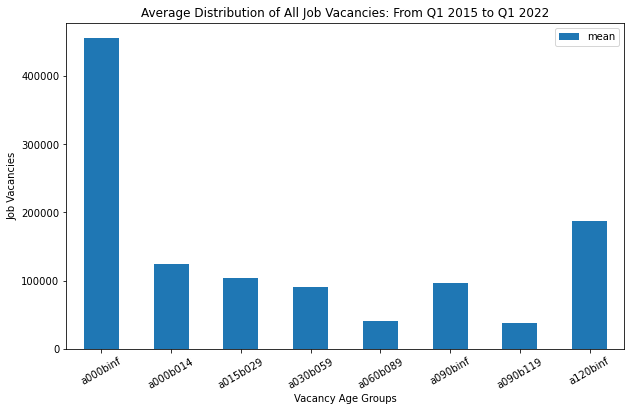

In [26]:
df_all.describe().loc[['mean']].iloc[:, 4:].T.plot(kind="bar")
plt.xticks(rotation=30, horizontalalignment="center")
plt.xlabel("Vacancy Age Groups")
plt.ylabel("Job Vacancies")
plt.title("Average Distribution of All Job Vacancies: From Q1 2015 to Q1 2022")
plt.show()

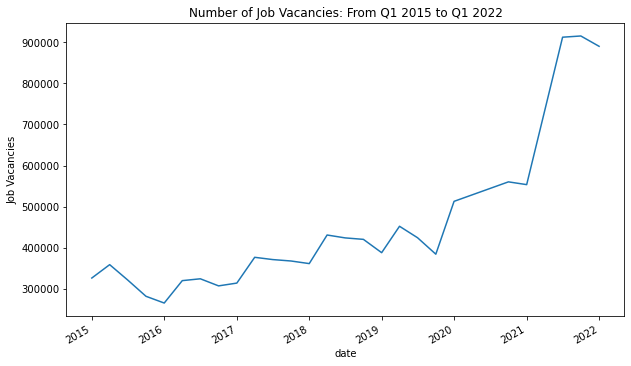

In [27]:
df_all_1 = date(df_all)
df_all_1 = df_all_1.set_index(['date'])
df_all_1['a000binf'].plot()
plt.xlabel("date")
plt.ylabel("Job Vacancies")
plt.title("Number of Job Vacancies: From Q1 2015 to Q1 2022")
plt.show()

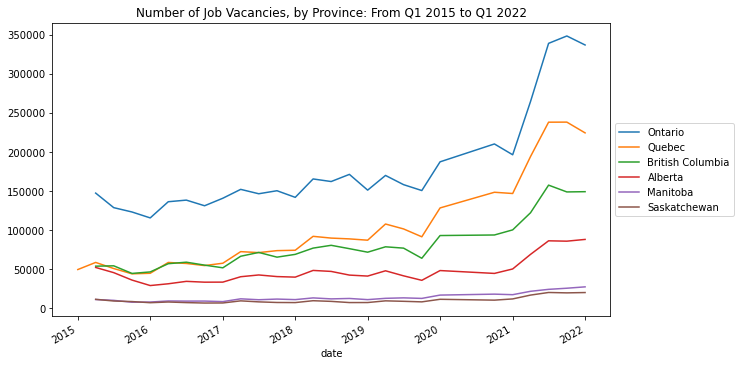

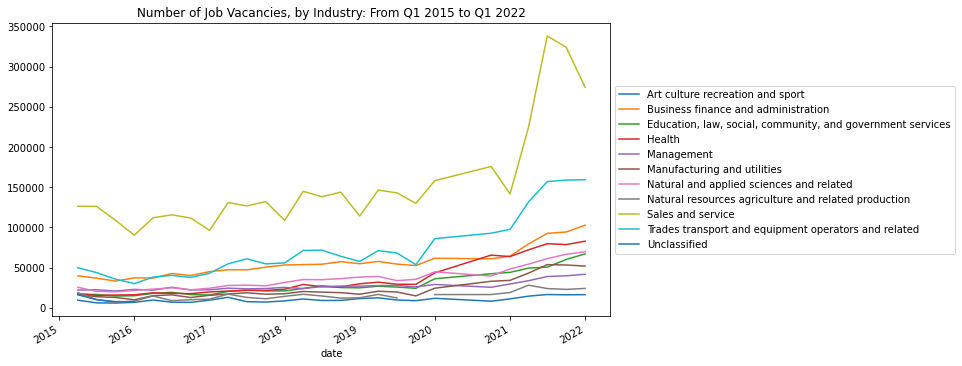

In [28]:
POV_stat = date(df_all).set_index(['date'])[['a000binf']].copy()
POV_stat = POV_stat.drop(columns=['a000binf'])
for i in POV_list:
    df = globals()[f'df_{i}']
    df = date(df).set_index(['date'])[['a000binf']]
    df.rename(columns = {'a000binf': i}, inplace = True)
    POV_stat = pd.merge(POV_stat, df, on = "date", how = "outer")
POV_stat.rename(columns = POVdict, inplace = True)
POV_stat.plot()
plt.title('Number of Job Vacancies, by Province: From Q1 2015 to Q1 2022')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


NOC_stat = date(df_all).set_index(['date'])[['a000binf']].copy()
NOC_stat = NOC_stat.drop(columns=['a000binf'])
for i in NOC_list:
    df = globals()[f'df_{i}']
    df = date(df).set_index(['date'])[['a000binf']]
    df.rename(columns = {'a000binf': i}, inplace = True)
    NOC_stat = pd.merge(NOC_stat, df, on = "date", how = "outer")
NOC_stat.rename(columns = NOCdict, inplace = True)
NOC_stat.plot()
plt.title('Number of Job Vacancies, by Industry: From Q1 2015 to Q1 2022')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Addtional Testing

In [29]:
def StandardError(df_residual):
    df_residual = df_residual.copy()
    #residual
    residual = []
    for j in df_residual:
        list0 = df_residual[j].dropna().tolist()
        residual += list0
    #n
    n = 0
    for i in df_residual.count():
        n += i
    a = 1 / (n - 1)
    b = sum([x ** 2 for x in residual])
    s = (a * b) ** 0.5
    return s

In [30]:
#Model Comparison
residualList = ['ε_a000b014', 'ε_a015b029', 'ε_a030b059', 'ε_a060b089', 'ε_a090b119',
                'ε_a090binf', 'ε_a120binf']
model1 = fitAll_all[0][residualList]
model2 = fitYear_all[residualList]
model3 = fitQuarter_all[residualList]

s_model1 = StandardError(model1)
s_model2 = StandardError(model2)
s_model3 = StandardError(model3)
print(s_model1)
print(s_model2)
print(s_model3)

67574.16025099508
44811.56854662302
39650.12653192208


In [40]:
#inf issue
def TEST_genDF0(df, df0, quarter):
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a000b014'],'a':float(0),'b':float(14), 'id':'a000b014'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a015b029'],'a':float(15),'b':float(29),'id':'a015b029'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a030b059'],'a':float(30),'b':float(59),'id':'a030b059'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a060b089'],'a':float(60),'b':float(89),'id':'a060b089'},ignore_index=True)
    df0 = df0.append({'year' : df.loc[quarter, 'year'], 'quarter' : df.loc[quarter, 'quarter'],
                      'V':df.loc[quarter,'a090b119'],'a':float(90),'b':float(119),'id':'a090b119'},ignore_index=True)
    df0 = df0[df0['V'].notna()]
    df0['V'] = df0['V'].astype(float, errors='ignore')
    return df0

def model1(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for quarter in range(len(df)):
        df0 = TEST_genDF0(df, df0, quarter)
    #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
    fit = fitting(df0, coeffs0) 
    #record
    v0 = fit.x[0]
    q = 1 - fit.x[1]
    ε = pd.Series(fit.fun)
    df0['ε'] = ε.values
    df['ε_a000binf'] = np.nan
    df['ε_a000b014'] = np.nan
    df['ε_a015b029'] = np.nan
    df['ε_a030b059'] = np.nan
    df['ε_a060b089'] = np.nan
    df['ε_a090binf'] = np.nan
    df['ε_a090b119'] = np.nan
    df['ε_a120binf'] = np.nan
    for i in range(len(df0)):
        ε_value = df0.loc[i, 'ε']
        year = df0.loc[i, 'year']
        quarter = df0.loc[i, 'quarter']
        id_name = df0.loc[i, 'id']
        df[f'ε_{id_name}'][(df["year"] == year) & (df["quarter"] == quarter)] = ε_value
    if q != 0.5:
        df['v0'] = v0
        df['q'] = q
    else:
        pass
    return df

def model2(df):
    df = df.copy()
    df0 = pd.DataFrame()
    for year in range(2015, 2022+1 ,1):
        dfYEAR = df[(df['year'] == year)].copy()
        dfYEAR.index = range(0,len(dfYEAR))
        try:
            fit = model1(dfYEAR) #[0]: table, [1]:V0, [2]: q
            dfYEAR = fit
            df0 = df0.append(dfYEAR)
        except:
            pass
    return df0

def model3(df):
    df = df.copy()
    for quarter in range(len(df)):
        df0 = pd.DataFrame()
        df0 = TEST_genDF0(df, df0, quarter)
        #fitting    v0 = coeffs[0] = , q = 1 - coeffs[1]
        if len(df0.index) >= 2:
            fit = fitting(df0, coeffs0) 
        #record
            v0 = fit.x[0]
            q = 1- fit.x[1]
            if q != coeffs0[1]:
                df.loc[quarter, 'v0'] = v0
                df.loc[quarter, 'q'] = q
            else:
                pass
            idList = df0['id'].tolist()
            for i in range(len(fit.fun)):
                df.loc[quarter, f'ε_{idList[i]}'] = fit.fun[i]
            df0 = df0.iloc[0:0] #clear df0
    return df

In [49]:
list1 = ['ε_a000b014', 'ε_a015b029', 'ε_a030b059', 'ε_a060b089', 'ε_a090b119', 'ε_a090binf', 'ε_a120binf']
list2 = ['ε_a000b014', 'ε_a015b029', 'ε_a030b059', 'ε_a060b089', 'ε_a090b119']
Model1_1 = fitAll_all[0]
Model2_1 = fitYear_all
Model3_1 = fitQuarter_all
Model1_2 = model1(df_all)
Model2_2 = model2(df_all)
Model3_2 = model3(df_all)

Model1_1 = date(Model1_1).set_index(['date'])
Model2_1 = date(Model2_1).set_index(['date'])
Model3_1 = date(Model3_1).set_index(['date'])
Model1_2 = date(Model1_2).set_index(['date'])
Model2_2 = date(Model2_2).set_index(['date'])
Model3_2 = date(Model3_2).set_index(['date'])

In [50]:
s_Model1_1 = StandardError(Model1_1[list2])
s_Model2_1 = StandardError(Model2_1[list2])
s_Model3_1 = StandardError(Model3_1[list2])
s_Model1_2 = StandardError(Model1_2[list2])
s_Model2_2 = StandardError(Model2_2[list2])
s_Model3_2 = StandardError(Model3_2[list2])

v0_Model1_1 = Model1_1['v0'].mean()
v0_Model2_1 = Model2_1['v0'].mean()
v0_Model3_1 = Model3_1['v0'].mean()
v0_Model1_2 = Model1_2['v0'].mean()
v0_Model2_2 = Model2_2['v0'].mean()
v0_Model3_2 = Model3_2['v0'].mean()

q_Model1_1 = Model1_1['q'].mean()
q_Model2_1 = Model2_1['q'].mean()
q_Model3_1 = Model3_1['q'].mean()
q_Model1_2 = Model1_2['q'].mean()
q_Model2_2 = Model2_2['q'].mean()
q_Model3_2 = Model3_2['q'].mean()

In [51]:
noInf = pd.DataFrame(data={'indicator': ['S', 'V0', 'q'],
                           'Model1a': [s_Model1_1, v0_Model1_1, q_Model1_1],
                           'Model1b': [s_Model1_2, v0_Model1_2, q_Model1_2],
                           'Model2a': [s_Model2_1, v0_Model2_1, q_Model2_1],
                           'Model2b': [s_Model2_2, v0_Model2_2, q_Model2_2],
                           'Model3a': [s_Model3_1, v0_Model3_1, q_Model3_1],
                           'Model3b': [s_Model3_2, v0_Model3_2, q_Model3_2]}).set_index(['indicator'])
noInf_diff = pd.DataFrame(data={'indicator': ['S', 'V0', 'q'],
                                'Model1_diff': noInf['Model1b']-noInf['Model1a'],
                                'Model2_diff': noInf['Model2b']-noInf['Model2a'],
                                'Model3_diff': noInf['Model3b']-noInf['Model3a']}).set_index(['indicator'])

display(noInf)
display(noInf_diff)

,Model1a,Model1b,Model2a,Model2b,Model3a,Model3b
indicator,,,,,,
S,"45,895.970","28,187.695","42,917.688","14,511.777","39,798.847","7,620.215"
V0,"5,727.879","10,435.332","7,721.951","10,562.076","7,862.348","10,648.906"
q,0.018,0.035,0.028,0.036,0.028,0.036


,Model1_diff,Model2_diff,Model3_diff
indicator,,,
S,"-17,708.275","-28,405.911","-32,178.632"
V0,"4,707.454","2,840.125","2,786.558"
q,0.017,0.008,0.008


In [45]:
#run all data
x = x
'''
fitAll_result[['v0']].plot(kind="bar")
plt.xlabel("")
plt.ylabel("the inflow of job vacancies (V0)")
plt.title("Estimated Inflow of Job Vacancies (V0), by Vacancy Characteristics")
plt.show()

fitAll_result[['q']].plot(kind="bar")
plt.xlabel("")
plt.ylabel("the daily Poisson arrival rate of a job vacancy being filled (q)")
plt.title("Estimated q for Job Vacancies, by Vacancy Characteristics")
plt.show()
'''

NameError: name 'x' is not defined

<AxesSubplot:xlabel='date'>

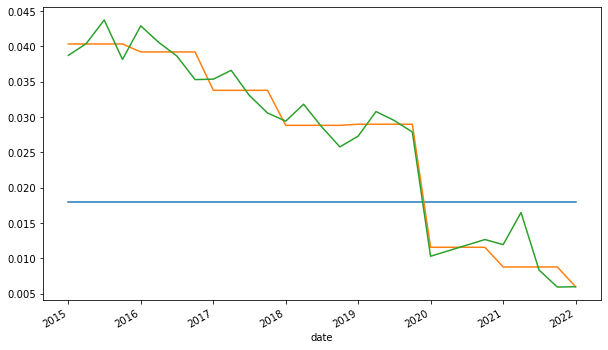

In [52]:
Model1_1['q'].plot()
Model2_1['q'].plot()
Model3_1['q'].plot()

<AxesSubplot:xlabel='date'>

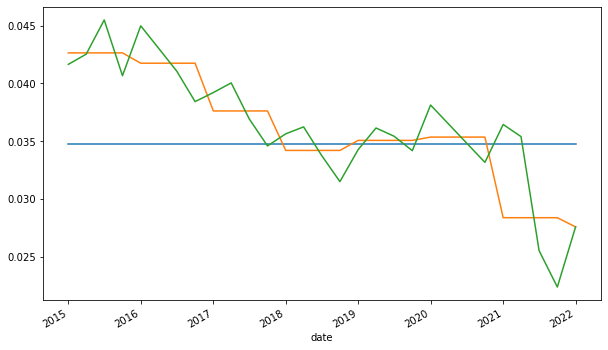

In [53]:
Model1_2['q'].plot()
Model2_2['q'].plot()
Model3_2['q'].plot()

In [48]:
Model2_2

,t,year,quarter,all,a000binf,a000b014,a015b029,a030b059,a060b089,a090binf,a090b119,a120binf,ε_a000binf,ε_a000b014,ε_a015b029,ε_a030b059,ε_a060b089,ε_a090binf,ε_a090b119,ε_a120binf,v0,q
0,1,2015,1,"408,125.000","325,995.000","113,260.000","83,630.000","64,160.000","25,115.000","39,830.000",NaN,NaN,NaN,"-1,158.718","7,986.122","-2,798.765","-7,504.799",NaN,NaN,NaN,"10,466.177",0.043
1,2,2015,2,"451,925.000","358,550.000","126,345.000","102,280.000","68,450.000","22,310.000","39,165.000",NaN,NaN,NaN,"-14,243.718","-10,663.878","-7,088.765","-4,699.799",NaN,NaN,NaN,"10,466.177",0.043
2,3,2015,3,"407,865.000","321,060.000","121,925.000","87,780.000","58,290.000","21,275.000","31,790.000",NaN,NaN,NaN,"-9,823.718","3,836.122","3,071.235","-3,664.799",NaN,NaN,NaN,"10,466.177",0.043
3,4,2015,4,"358,755.000","281,500.000","96,690.000","75,190.000","57,310.000","21,110.000","31,200.000",NaN,NaN,NaN,"15,411.282","16,426.122","4,051.235","-3,499.799",NaN,NaN,NaN,"10,466.177",0.043
0,5,2016,1,"330,215.000","265,055.000","98,600.000","71,795.000","48,650.000","16,660.000","29,350.000",NaN,NaN,NaN,"4,822.815","14,336.639","10,209.683",760.187,NaN,NaN,NaN,"9,603.920",0.042
1,6,2016,2,"391,190.000","319,630.000","113,035.000","87,695.000","59,525.000","21,595.000","37,780.000",NaN,NaN,NaN,"-9,612.185","-1,563.361",-665.317,"-4,174.813",NaN,NaN,NaN,"9,603.920",0.042
2,7,2016,3,"404,860.000","324,110.000","111,330.000","89,330.000","64,380.000","23,200.000","35,870.000",NaN,NaN,NaN,"-7,907.185","-3,198.361","-5,520.317","-5,779.813",NaN,NaN,NaN,"9,603.920",0.042
3,8,2016,4,"381,010.000","306,840.000","99,275.000","80,880.000","64,735.000","24,525.000","37,425.000",NaN,NaN,NaN,"4,147.815","5,251.639","-5,875.317","-7,104.813",NaN,NaN,NaN,"9,603.920",0.042
0,9,2017,1,"387,080.000","313,645.000","100,235.000","82,725.000","62,370.000","24,125.000","44,190.000",NaN,NaN,NaN,"8,045.818","15,714.199","11,580.685","1,150.182",NaN,NaN,NaN,"9,805.414",0.038
1,10,2017,2,"459,685.000","376,445.000","123,895.000","99,145.000","76,490.000","25,875.000","51,040.000",NaN,NaN,NaN,"-15,614.182",-705.801,"-2,539.315",-599.818,NaN,NaN,NaN,"9,805.414",0.038


<AxesSubplot:xlabel='date'>

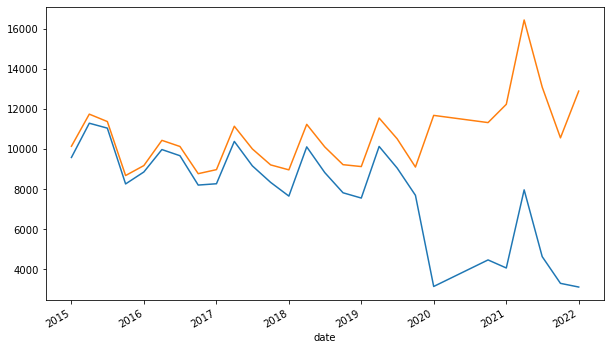

In [54]:
Model3_1['v0'].plot()
Model3_2['v0'].plot()

<AxesSubplot:xlabel='date'>

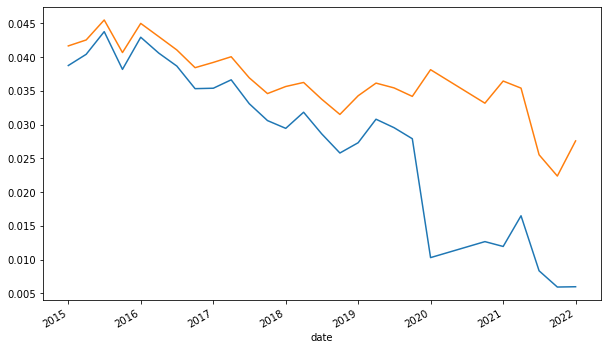

In [55]:
Model3_1['q'].plot()
Model3_2['q'].plot()